# Toy Data Solution

In [1]:
import numpy as np
#import pandas as pd
import torch
import torch.nn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

/Users/brane/opt/miniconda3/envs/spacy31/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.1 Generating synthetic data

Make function `generate_toydata()` that recieves:
* `batch_size` - number of datapoints
* `w` - multipliyer of linear function
* `b` - offset of linear function

and returns two vectors:
* `X` of shape (batch_size, 2) containing 2D datapoints
* `Y` if shape (batch_size,) containing targets.

This function generates random batch size number of 2D points $(x_1, x_2)$ where:
* $x_1$ are random numbers and
* $x_2$ are random numbers multiplied by $w$ and to which $b$ is added.

Target ($y$) of $(x_1, x_2)$ will be:
* $1$ if $x_2 > w * x_1 + b$
* else $0$



In [2]:
def generate_toy_data(batch_size, w, b):
    x1 = torch.rand(batch_size)
    x2 = torch.rand(batch_size) * w + b
    assert x1.shape == x2.shape == (batch_size, )
    
    x_data = torch.stack((x1, x2)).T
    assert x_data.shape == (batch_size, 2)
    
    y_target = (x2 > w * x1 + b).float()
    assert y_target.shape == (batch_size, )
    
    return x_data, y_target
    

x_data, y_truth = generate_toy_data(10, w=5, b=3)
x_data, y_truth

(tensor([[0.0783, 6.5428],
         [0.4956, 5.9047],
         [0.6231, 3.2869],
         [0.4224, 6.8343],
         [0.2004, 7.3892],
         [0.0287, 4.2168],
         [0.5851, 6.0026],
         [0.6967, 6.5396],
         [0.1761, 5.5510],
         [0.2595, 5.0327]]),
 tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1.]))

# 1.2 Plotting data

Create function `plot_toy_data()` which receives two vectors:
* $X$ vector of n datapoints $(x_1, x_2)$
* $Y$ vector of n targets

This function plots 2D datapoints in blue if corresponding target value is 1, red if opposite.

Generate 1000 synthetic data points where $w$ = 5 and $b$ = 3.

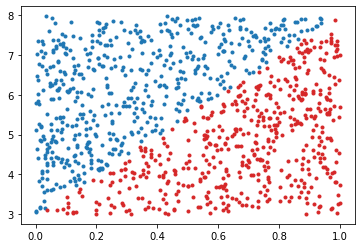

In [3]:
def plot_toy_data(x_data, y_truth, perceptron=None):
    blue = []
    orange = []
    black_blue = []
    black_orange = []
    if perceptron:
        y_pred = perceptron(x_data).squeeze().detach()
        y_pred = (y_pred > 0.5).float()
    else:
        y_pred = y_truth

    for x_i, y_true_i, y_pred_i in zip(x_data, y_truth, y_pred):
        
        is_black = y_true_i != y_pred_i

        if y_true_i == 1.:
            if is_black:
                black_blue.append(x_i)
            else:
                blue.append(x_i)
        else:
            if is_black:
                black_orange.append(x_i)
            else:
                orange.append(x_i)
    
    if blue:
        blue = np.stack(blue)
        plt.scatter(blue[:,0], blue[:,1], marker=".", c="tab:blue")
    
    if orange:
        orange = np.stack(orange)
        plt.scatter(orange[:,0], orange[:,1], marker=".", c="tab:red")

    if perceptron:
        if black_blue:
            black_blue = np.stack(black_blue)
            plt.scatter(black_blue[:,0], black_blue[:,1], marker=".", c="black")
        if black_orange:
            black_orange = np.stack(black_orange)
            plt.scatter(black_orange[:,0], black_orange[:,1], marker=".", c="black")

        # hyperplane
        xx = np.linspace(x_data[:,0].min(), x_data[:,0].max(), 30)
        yy = np.linspace(x_data[:,1].min(), x_data[:,1].max(), 30)
        xv, yv = np.meshgrid(xx, yy)
        xy = np.vstack([xv.ravel(), yv.ravel()]).T
        z = perceptron(torch.tensor(xy, dtype=torch.float)).detach().numpy().reshape(yv.shape)
        
        plt.contour(xx, yy, z, colors='k', linestyles=["--", "-", "--"], levels=[0.4, 0.5, 0.6])
    plt.show()

plot_toy_data(*generate_toy_data(1024, w=5, b=3))
# plot_toy_data(*get_toy_data(1024), perceptron)


# 2.1. Perceptron

Create `Perceptron` class where perceptron receives 2 numbers and outputs 1 number.  
Create `forward()` method which receives datapoint $(x_1, x_2)$ which is an input to perceptron and applyies sigmoid on perceptron's output.

In [4]:
class Perceptron(torch.nn.Module):

    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(2, 1)

    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in))
    
    def predict(self, x_in):
        return 1 if self.forward(x_in) > 0.5 else 0

x = torch.FloatTensor([[1, 2], [3, 4]])
#x = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
perceptron = Perceptron()
perceptron(x)

tensor([[0.7812],
        [0.8635]], grad_fn=<SigmoidBackward0>)

Set following variables:
* learning rate `lr` to 0.01
* `batch_size` = 1000
* `w` = 90
* `b` = 6

Instantiate:
* perceptron, 
* adam optimizer with defined learning rate, 
* binary cross-entropy loss, 
* `losses` as empty list

Generate and remember static toy data with predefined parameters.

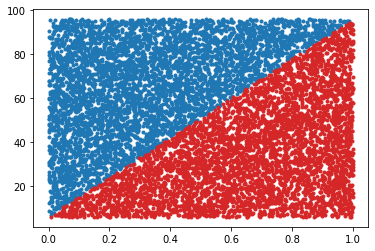

In [18]:
lr = 0.01
batch_size = 10000
W = 90
B = 6

perceptron = Perceptron()
optimizer = torch.optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = torch.nn.BCELoss()

losses = []

x_data_static, y_truth_static = generate_toy_data(batch_size, w=W, b=B)
plot_toy_data(x_data_static, y_truth_static)

# 2.2 Train

Set following variables:
* `change` to 1.0 - it will be absolute difference between current and previous loss
* `last` to 10 - previous loss
* `epsilon` to $10^{-3}$ - limiter of change
* `n_epochs` to 12  - number of epochs
* `n_batches` to 5 - number of batches
* `epoch`to 0 - current epoch number

**Train procedure**

While change > epsilon or current epoch < number of epochs or last loss > 0.15  
then for each batch:
* make forward step, 
* append to `losses` current loss
* calculate `change`
* set `last` to current loss  
At the end of batch loop increment `epoch`.

.............
epoch: 13 loss: 0.142


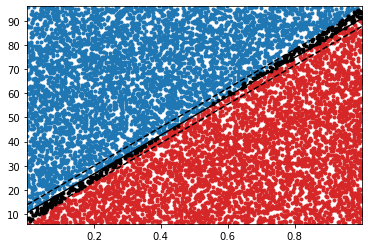

In [25]:
change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0

batch_size = 10000
n_epochs = 12
n_batches = 5


while change > epsilon or epoch < n_epochs or last > 0.15:

#for epoch in range(n_epochs):
    for _ in range(n_batches):
        optimizer.zero_grad()
        data = generate_toy_data(batch_size, w=W, b=B)
        x_data, y_target = data
        y_pred = perceptron(x_data).squeeze()
        
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
        
    print(".", end="")
    epoch += 1
print(f"\nepoch: {epoch} loss: {loss:0.3}\r")     
plot_toy_data(x_data_static, y_truth_static, perceptron)

Plot losses

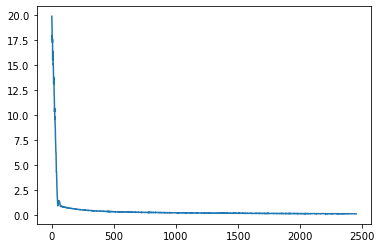

In [26]:
plt.plot(range(len(losses)), losses)

# 2.3 Evaluate

Evaluate model on static data. calculate accuracy, precission, recall and f1. Printout confusion matrix.

Note: You can use `scikitlearn.metrics`

In [27]:


y_pred = (perceptron(x_data_static).squeeze() > 0.5).float()
#y_pred = perceptron(x_data_static).squeeze()


acc = accuracy_score(y_truth_static, y_pred)
p = precision_score(y_truth_static, y_pred)
r = recall_score(y_truth_static, y_pred)
f1 = f1_score(y_truth_static, y_pred)

print(f"acc: {acc:.3f}", )
print(f"p: {p:.3f}", )
print(f"r: {r:.3f}", )
print(f"f1: {f1:.3f}\n")

[[tn, fp], [fn, tp]] = confusion_matrix(y_truth_static, y_pred)
print(f"tn: {tn}  fp: {fp}")
print(f"fn: {fn}  tp: {tp}")

acc: 0.971
p: 0.970
r: 0.972
f1: 0.971

tn: 4776  fp: 150
fn: 141  tp: 4933


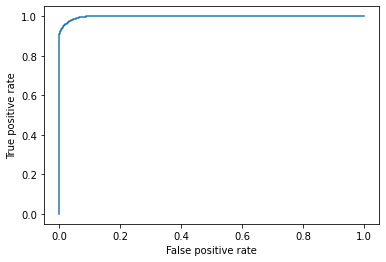

In [28]:
fpr, tpr, th1 = roc_curve(y_truth_static, perceptron(x_data_static).detach().clone().squeeze().numpy())

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr, tpr)

# 2.4. Interspect

Determine learnt weights and compare them to `W` and `B` parameters used for generating toy data.

In [29]:
ins, outs = perceptron.parameters()
w1, w2 = ins.detach().clone().numpy()[0]
b = outs.detach().clone().numpy()[0]

print((w1, w2), b)

(-9.942847, 0.12366347) -1.3037527


In [30]:
w = -w1/w2
b = -b/w2

print(f"model parameters: {w:.2f} {b:.2f}")
print(f"toy data generator parameters: {W:.2f} {B:.2f}")

model parameters: 80.40 10.54
toy data generator parameters: 90.00 6.00


**model**

$ x_1 * w_1 + x_2 * w_2 + b = 0 $  
$ x_2 * w_2 = - x_1 * w_1 - b $  
$ x_2 = - \frac{w_1}{w_2} x_1 - \frac{b}{w_2} $  

**data**

$ x_2 = W * x_1 + B $
